# 중간고사: 컴퓨터 비전 문제

### 목표: 간단한 컨볼루션 신경망(CNN)을 사용하여 이미지 분류 작업을 수행합니다. 이 과제에서는 Fashion-MNIST 데이터셋을 사용합니다. Pytorch로 구현하세요.
- Python 환경 : Python 3.10.13

### 1. 환경 구축
---------------------------------------------------
#### - PyTorch와 컴퓨터 비전 관련 패키지들을 설치 
#### - 필요한 스크립트 파일을 다운로드
---------------------------------------------------


In [11]:
# pytorchcv.py 파일을 다운로드하기 위해 wget 명령어를 사용할 수 없으므로, 직접 다운로드 링크를 제공합니다.
# 이하의 코드는 pytorchcv.py 파일을 다운로드하는 목적입니다.
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

# torchvision 패키지 설치를 위한 pip 명령어입니다.
%pip install torchvision

# torchinfo 패키지 설치를 위한 pip 명령어입니다.
%pip install torchinfo

# pytorchcv 패키지 설치를 위한 pip 명령어입니다.
%pip install pytorchcv

# torchsummary 패키지 설치를 위한 pip 명령어입니다.
%pip install torchsummary

--2024-04-24 12:27:01--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py.13’

pytorchcv.py.13     100%[===================>]   6.39K  --.-KB/s    in 0.001s  

2024-04-24 12:27:01 (11.1 MB/s) - ‘pytorchcv.py.13’ saved [6540/6540]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 2. 임포트
---------------------------------------------------
#### - 파이토치와 관련된 라이브러리들을 임포트합니다.
---------------------------------------------------

In [12]:
# 파이토치와 관련된 라이브러리들을 임포트합니다.
import torch
import torch.nn as nn  # 파이토치의 신경망 모듈(nn)을 임포트합니다.
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pytorchcv
from pytorchcv import load_Fashionmnist, train, plot_results, plot_convolution, display_dataset

# Fashion MNIST 데이터셋을 로드하고 배치 크기를 128로 설정합니다.
load_Fashionmnist(batch_size=128)

# 설치된 torchsummary에서 summary 함수를 임포트합니다.
from torchsummary import summary

# 리스트의 요소 수를 쉽게 계산하기 위해 Counter 모듈을 임포트합니다.
from collections import Counter


### 3. 이미지 변환
---------------------------------------------------
#### - 이미지 변환을 위한 파이토치의 transforms 모듈을 사용하여 변환 파이프라인을 정의합니다.
---------------------------------------------------

In [13]:
# 이미지 변환을 정의합니다.
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서 형태로 변환합니다.
])

### 4. 학습용(train) 데이터셋과 검증용(test) 데이터셋을 각각 로드
---------------------------------------------------
#### - datasets.FashionMNIST 함수를 사용하여 FashionMNIST 데이터셋을 로드합니다.
- root 인자는 데이터셋이 저장될 디렉토리를 지정
- train 인자는 학습용인지 검증용인지를 설정
- download 인자는 데이터셋을 인터넷에서 다운로드할지 여부를 결정
- transform 인자에는 이미지 변환 함수를 적용
---------------------------------------------------

In [14]:
# 학습용 데이터셋을 로드합니다.
train_data = datasets.FashionMNIST(root='data', 
                                   train=True,         # 학습용 데이터셋 설정(True)
                                   download=True, 
                                   transform=transform  # 이미지 변환을 적용합니다.
                                  )

# 검증용 데이터셋을 로드합니다.
test_data = datasets.FashionMNIST(root='data', 
                                  train=False,         # 검증용 데이터셋 설정(False)
                                  download=True, 
                                  transform=transform  # 이미지 변환을 적용합니다.
                                 )


### 5. FashionMNIST 데이터셋에서 무작위 샘플을 선택하여 시각화
---------------------------------------------------
#### - 데이터셋에서 무작위로 샘플을 선택하여 시각화
#### - 각 이미지의 클래스 레이블을 제목으로 표시
---------------------------------------------------

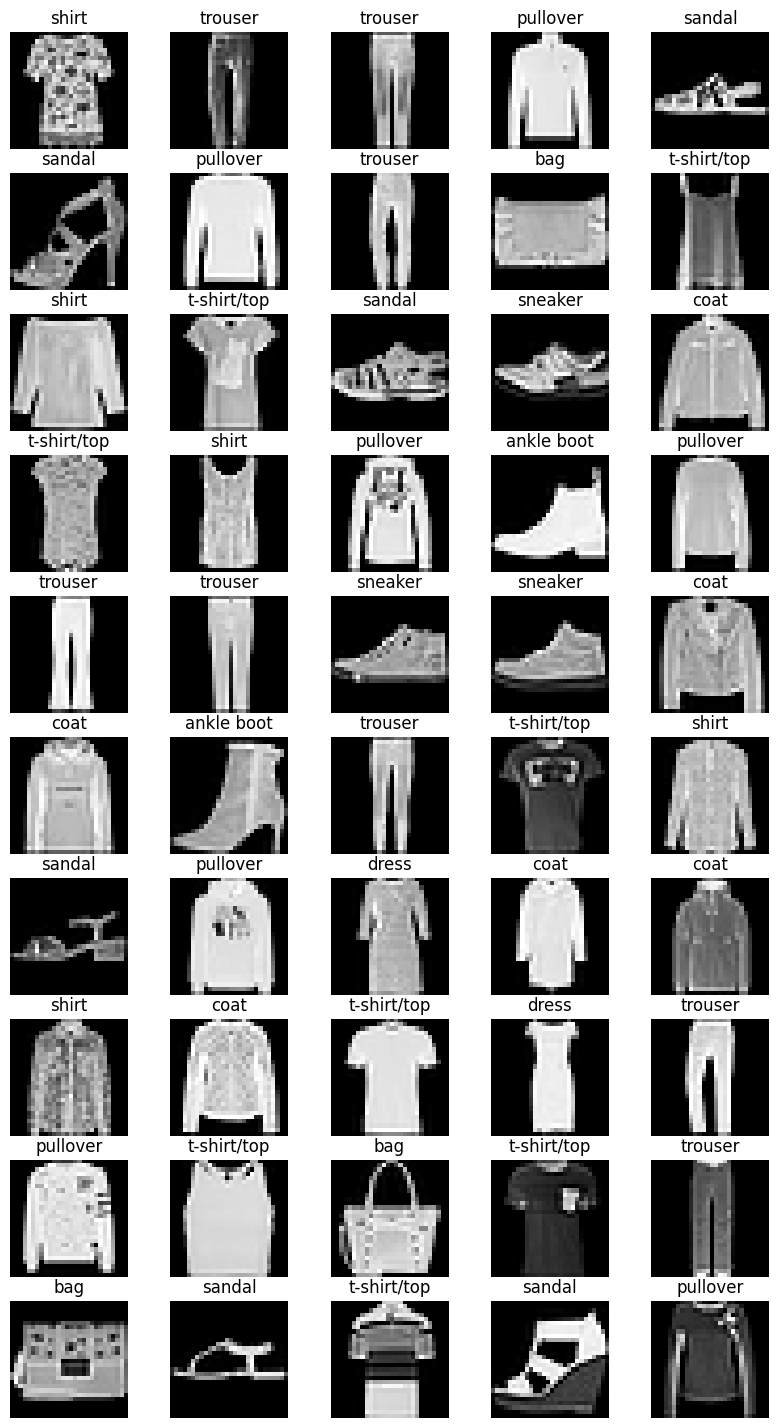

In [15]:
# 각 클래스 레이블에 대한 매핑입니다.
labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

# 시각화할 그림의 크기를 설정합니다.
figure = plt.figure(figsize=(10, 18))
cols, rows = 5, 10

# 무작위로 선택된 샘플을 시각화합니다.
for i in range(1, cols * rows + 1):
    # 학습 데이터셋에서 무작위로 샘플을 선택합니다.
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    
    # 그림에 subplot을 추가하고, 레이블과 이미지를 표시합니다.
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 이미지를 시각화하기 위해 채널을 변경합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
    
# 그림을 표시합니다.
plt.show()


### 6. 데이터로더에 사용될 배치 크기와 병렬 처리를 위한 쓰레드 숫자를 지정
---------------------------------------------------
#### - batch_size는 한 번에 처리할 데이터의 개수를 지정
- 너무 작으면 학습 속도가 느려지고, 너무 크면 메모리 부족으로 인해 학습이 실패할 수 있습니다. 

#### - num_workers는 데이터를 로드할 때 사용할 쓰레드의 개수를 지정
- 데이터를 병렬로 로드하여 학습 속도를 향상시키는 데 도움이 됩니다.
---------------------------------------------------

In [16]:
batch_size = 32  # 한 번에 처리할 데이터의 개수를 지정합니다. (배치 크기)
num_workers = 8  # 데이터를 로드할 때 사용할 쓰레드(thread)의 개수를 지정합니다. (병렬 처리에 활용됩니다.)

### 7. 학습 데이터와 검증 데이터에 대한 데이터로더를 생성
---------------------------------------------------
#### - torch.utils.data.DataLoader 함수를 사용하여 데이터로더를 생성
- train_data와 test_data는 데이터셋을 로드한 변수
- batch_size는 한 번에 로드할 데이터의 개수를 지정
- shuffle=True는 데이터를 매 에포크(epoch)마다 섞을지 여부를 결정
    - 학습할 때 데이터를 섞는 것이 좋습니다. 
- num_workers는 데이터를 로드할 때 사용할 병렬 처리 워커 스레드의 수를 지정
---------------------------------------------------

In [17]:
# 학습 데이터로더를 생성합니다.
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,   # 배치 크기 설정
                                           shuffle=True,            # 데이터를 섞어 학습에 활용합니다.
                                           num_workers=num_workers) # 병렬 처리에 사용할 워커 스레드 수를 설정합니다.

# 검증 데이터로더를 생성합니다.
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,   # 배치 크기 설정
                                          shuffle=False,           # 데이터를 섞지 않습니다.
                                          num_workers=num_workers) # 병렬 처리에 사용할 워커 스레드 수를 설정합니다.


## 8. 간단한 컨볼루션 신경망 모델을 정의하고, 해당 모델의 구조를 요약하는 과정을 설명
---------------------------------------------------
#### - OneConv 클래스는 nn.Module을 상속받아 신경망 모델을 정의
- __init__ 메서드에서는 모델의 각 레이어를 초기화
- forward 메서드에서는 입력 데이터가 모델을 통과하는 과정을 정의
- 이후에는 모델의 인스턴스를 생성
- summary 함수를 사용하여 모델의 구조를 요약하여 출력
---------------------------------------------------

In [18]:
class OneConv(nn.Module): 
    def __init__(self): 
        super(OneConv, self).__init__() 
        # 컨볼루션 레이어 정의: 입력 채널이 1개이고, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5,5)) 
        # 평탄화 레이어 정의: 다차원 입력을 1차원 배열로 평탄화하는 Flatten 레이어를 정의
        self.flatten = nn.Flatten() 
        # 완전 연결 레이어 정의: 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어를 정의
        self.fc = nn.Linear(5184, 10) 

    def forward(self, x): 
        # 예상치 못한 추가 차원을 제거하여 입력을 4차원 텐서로 변환
        if x.dim() == 5 and x.size(2) == 1:
            x = x.squeeze(2)
        # 컨볼루션 레이어에 입력을 적용하고 ReLU 활성화 함수를 적용
        x = nn.functional.relu(self.conv(x)) 
        # 평탄화 레이어를 통해 다차원 입력을 1차원 배열로 변환
        x = self.flatten(x) 
        # 완전 연결 레이어에 적용하고 로그 소프트맥스 함수를 통해 결과를 처리
        x = nn.functional.log_softmax(self.fc(x), dim=1) 

        return x 

# 네트워크의 인스턴스 생성
net = OneConv() 

# 모델의 요약 정보 출력
summary(net, input_size=(1, 1, 28, 28)) 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


## 9. PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 함수를 구현
---------------------------------------------------
#### - 위 과정을 통해 주어진 모델을 학습하고 테스트하여 모델의 성능을 평가할 수 있습니다.

In [19]:
import torch
from torch import optim

def train(model, train_loader, test_loader, epochs=5):
    # CUDA를 사용할 수 있는 경우 GPU를 사용하고, 그렇지 않으면 CPU를 사용합니다.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # 모델을 해당 장치로 이동합니다.
    
    # Adam 옵티마이저를 사용하여 모델의 매개변수를 최적화합니다.
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # 크로스 엔트로피 손실 함수를 사용합니다.
    criterion = torch.nn.CrossEntropyLoss()
    
    # 학습 및 테스트 과정에서의 손실 및 정확도를 기록하기 위한 history 딕셔너리를 초기화합니다.
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    try:
        # 주어진 에폭 수만큼 반복하여 모델을 학습하고 검증합니다.
        for epoch in range(epochs):
            model.train()  # 모델을 학습 모드로 설정합니다.
            train_loss, train_correct, train_total = 0, 0, 0
            
            # 학습 데이터셋을 사용하여 모델을 학습합니다.
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()  # 그래디언트를 초기화합니다.
                output = model(data)  # 모델을 통해 예측을 수행합니다.
                loss = criterion(output, target)  # 손실을 계산합니다.
                loss.backward()  # 역전파를 통해 그래디언트를 계산합니다.
                optimizer.step()  # 최적화 도구로 매개변수를 업데이트합니다.
                
                # 정확도와 손실을 기록합니다.
                train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            # 평균 손실과 정확도를 계산합니다.
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()  # 모델을 평가 모드로 설정합니다.
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                # 검증 데이터셋을 사용하여 모델을 평가합니다.
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            # 평균 검증 손실과 정확도를 계산합니다.
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            # 에폭마다 학습 및 검증 결과를 출력합니다.
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e:
        # 에러가 발생하면 해당 에러 메시지를 출력하고 None을 반환합니다.
        print(f"An error occurred: {e}")
        return None
    
    return history  # 학습 및 검증 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환합니다.


## 10. 신경망 모델을 학습시키고 결과를 처리하는 과정
---------------------------------------------------
#### - train 함수를 호출하여 신경망 모델을 학습
#### - 학습 데이터 로더(train_loader)와 테스트 데이터 로더(test_loader)를 사용하고, 총 10 에폭 동안 학습을 수행
#### - train 함수에서 반환된 학습 결과(hist)를 확인
- 만약 학습 결과가 None인 경우, 학습이 실패했거나 예외가 처리되었음을 의미
- 이 경우, "Training did not return any history."라는 메시지를 출력
- 학습 결과가 유효한 경우, plot_results 함수를 호출하여 학습 결과를 시각화

---------------------------------------------------

Epoch 1/5: Train Loss: 0.0140, Train Acc: 84.29%, Test Loss: 0.0120, Test Acc: 86.74%
Epoch 2/5: Train Loss: 0.0103, Train Acc: 88.28%, Test Loss: 0.0109, Test Acc: 87.38%
Epoch 3/5: Train Loss: 0.0091, Train Acc: 89.58%, Test Loss: 0.0103, Test Acc: 88.46%
Epoch 4/5: Train Loss: 0.0084, Train Acc: 90.31%, Test Loss: 0.0102, Test Acc: 88.43%
Epoch 5/5: Train Loss: 0.0077, Train Acc: 90.94%, Test Loss: 0.0099, Test Acc: 89.25%


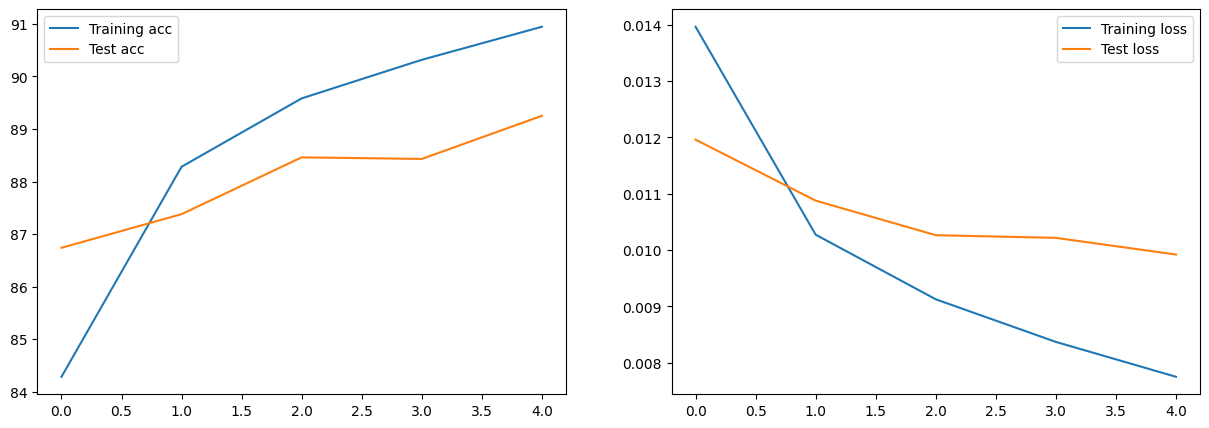

In [20]:
# train 함수를 호출하여 신경망 모델 net을 학습시키고 결과를 처리하는 과정을 수행합니다.
hist = train(net, train_loader, test_loader, epochs= 5)

if hist is None:
    # 만약 hist가 None인 경우, 학습이 실패했거나 예외가 처리되었음을 의미합니다.
    print("Training did not return any history.")
else:
    # hist가 None이 아닌 경우, 학습 결과를 시각화합니다.
    plot_results(hist)

## 11. 모델의 정확도를 평가하고, 잘못 분류된 이미지를 식별하며, 각 클래스의 분류 빈도를 계산
---------------------------------------------------
#### - 함수는 주어진 모델과 테스트 데이터 로더를 사용하여 모델의 정확도를 계산
#### - 잘못 분류된 이미지를 식별하며, 각 클래스의 분류 빈도를 계산
---------------------------------------------------

In [21]:
def evaluate_model_accuracy(model, test_loader):
    # GPU 사용 가능 여부 확인
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # 모델을 평가 모드로 설정
    test_correct = 0  # 올바르게 분류된 샘플 수 초기화
    test_total = 0  # 전체 테스트 샘플 수 초기화
    misclassified_images = []  # 잘못 분류된 이미지 저장할 리스트 초기화
    label_counts = {class_idx: 0 for class_idx in range(10)}  # 클래스별 분류 빈도를 저장할 딕셔너리 초기화

    with torch.no_grad():  # 그라디언트 계산 비활성화
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # 이미지와 레이블을 GPU로 이동
            outputs = model(images)  # 모델에 이미지 전달하여 출력 계산
            _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 갖는 클래스 선택
            test_total += labels.size(0)  # 배치 내 샘플 수 누적
            test_correct += (predicted == labels).sum().item()  # 올바르게 분류된 샘플 수 누적
            misclassified_indices = (predicted != labels).nonzero()  # 잘못 분류된 샘플 인덱스 확인
            for index in misclassified_indices:
                misclassified_images.append((images[index], labels[index], predicted[index]))  # 잘못 분류된 이미지 저장
                mis_class = int(predicted[index])  # 잘못 분류된 클래스
                true_class = int(labels[index])  # 실제 클래스
                label_counts[mis_class] += 1  # 잘못 분류된 클래스의 빈도를 증가

    test_accuracy = 100 * test_correct / test_total  # 정확도 계산

    sorted_label_counts = sorted(label_counts.items())  # 클래스별 분류 빈도를 정렬

    return test_accuracy, misclassified_images, sorted_label_counts

# 모델 평가 및 결과 출력
test_accuracy, misclassified_images, sorted_label_counts = evaluate_model_accuracy(net, test_loader)
print(f"최종 정확도: {test_accuracy:.2f}%")
print(f"잘못 분류된 이미지 개수: {len(misclassified_images)}")

최종 정확도: 89.25%
잘못 분류된 이미지 개수: 1075


## 12. 잘못 분류된 이미지를 클래스별로 정리하고, 각 클래스별로 잘못 분류된 이미지의 빈도를 시각화하는 그래프를 생성
---------------------------------------------------
#### - 함수는 주어진 모델과 테스트 데이터 로더를 사용하여 모델의 정확도를 계산
#### - 잘못 분류된 이미지를 식별하며, 각 클래스의 분류 빈도를 계산
---------------------------------------------------

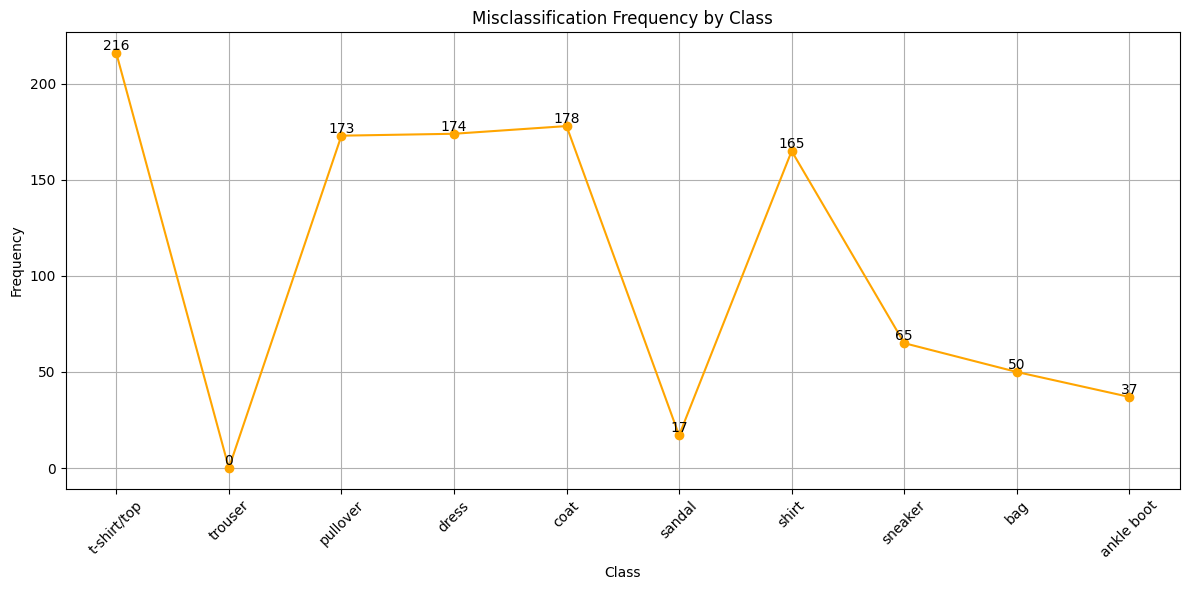

In [22]:
# 그래프로 시각화
plt.figure(figsize=(12, 6))

# 꺾은 선 그래프 그리기
plt.plot([labels_map[class_idx] for class_idx, _ in sorted_label_counts], [count for _, count in sorted_label_counts], marker='o', color='orange', linestyle='-')

# 그래프 제목, 축 라벨 설정
plt.title('Misclassification Frequency by Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)

# 꺾은 선 그래프 위에 숫자 표시
for label, count in zip([labels_map[class_idx] for class_idx, _ in sorted_label_counts], [count for _, count in sorted_label_counts]):
    plt.text(label, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 13. 각 클래스별로 모델이 얼마나 잘못 분류했는지를 시각적으로 확인
---------------------------------------------------
#### - 각 클래스별 잘못 분류된 이미지의 비율을 계산
#### - 계산된 비율을 바탕으로 막대 그래프를 출력
#### - 막대 위에 해당 클래스의 잘못 분류된 이미지 비율을 표시
---------------------------------------------------

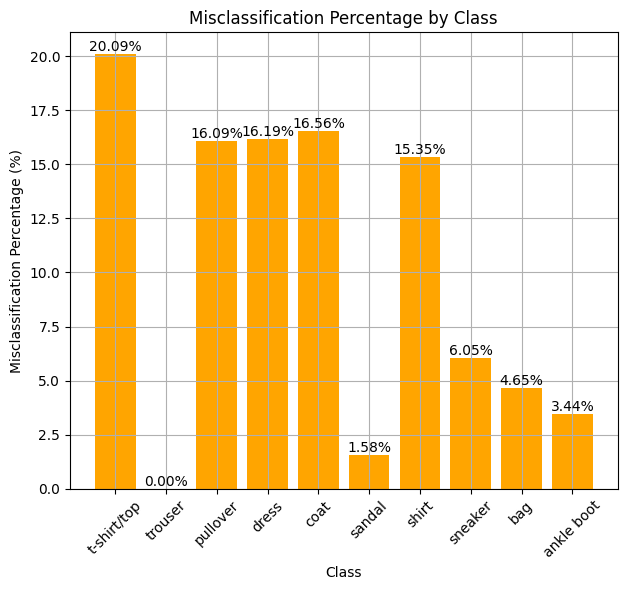

In [23]:
# 클래스별 잘못 분류된 이미지 비율 계산
total_misclassified = len(misclassified_images)
class_misclassification_percentages = [(labels_map[class_idx], count / total_misclassified * 100) for class_idx, count in sorted_label_counts]

# 그래프로 시각화
plt.figure(figsize=(12, 6))

# 막대 그래프 그리기
plt.subplot(1, 2, 2)
bar_plot = plt.bar([class_name for class_name, _ in class_misclassification_percentages], [percentage for _, percentage in class_misclassification_percentages], color='orange')
plt.title('Misclassification Percentage by Class')  # 그래프 제목 설정
plt.xlabel('Class')  # x축 라벨 설정
plt.ylabel('Misclassification Percentage (%)')  # y축 라벨 설정
plt.xticks(rotation=45)  # x축 라벨 회전
plt.grid(True)  # 그리드 표시

# 막대 위에 숫자 표시
for rect, percentage in zip(bar_plot, [percentage for _, percentage in class_misclassification_percentages]):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{percentage:.2f}%', ha='center', va='bottom')  # 막대 위에 숫자 표시

plt.tight_layout()
plt.show()
